In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


### Getting the data ready

Fizemos um resize para que todas as imagens tenham a mesma dimensão, a dimensão que a VGG aceita como entrada. Aplicamos algumas transformações (data augmentation) de RandomFlip e RandomRotation, além de normalizar com a média e desvio padrão das imagens do ImageNet (já que a VGG foi treinada nesse dataset).

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
dataset = datasets.ImageFolder(root='data', transform=data_transforms)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 4600
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# dividimos os dados em 80% treinamento, 10% validação e 10% teste
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - val_size - train_size

(test_size/dataset_size, val_size/dataset_size, train_size/dataset_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Mostrando algumas imagens do dataset

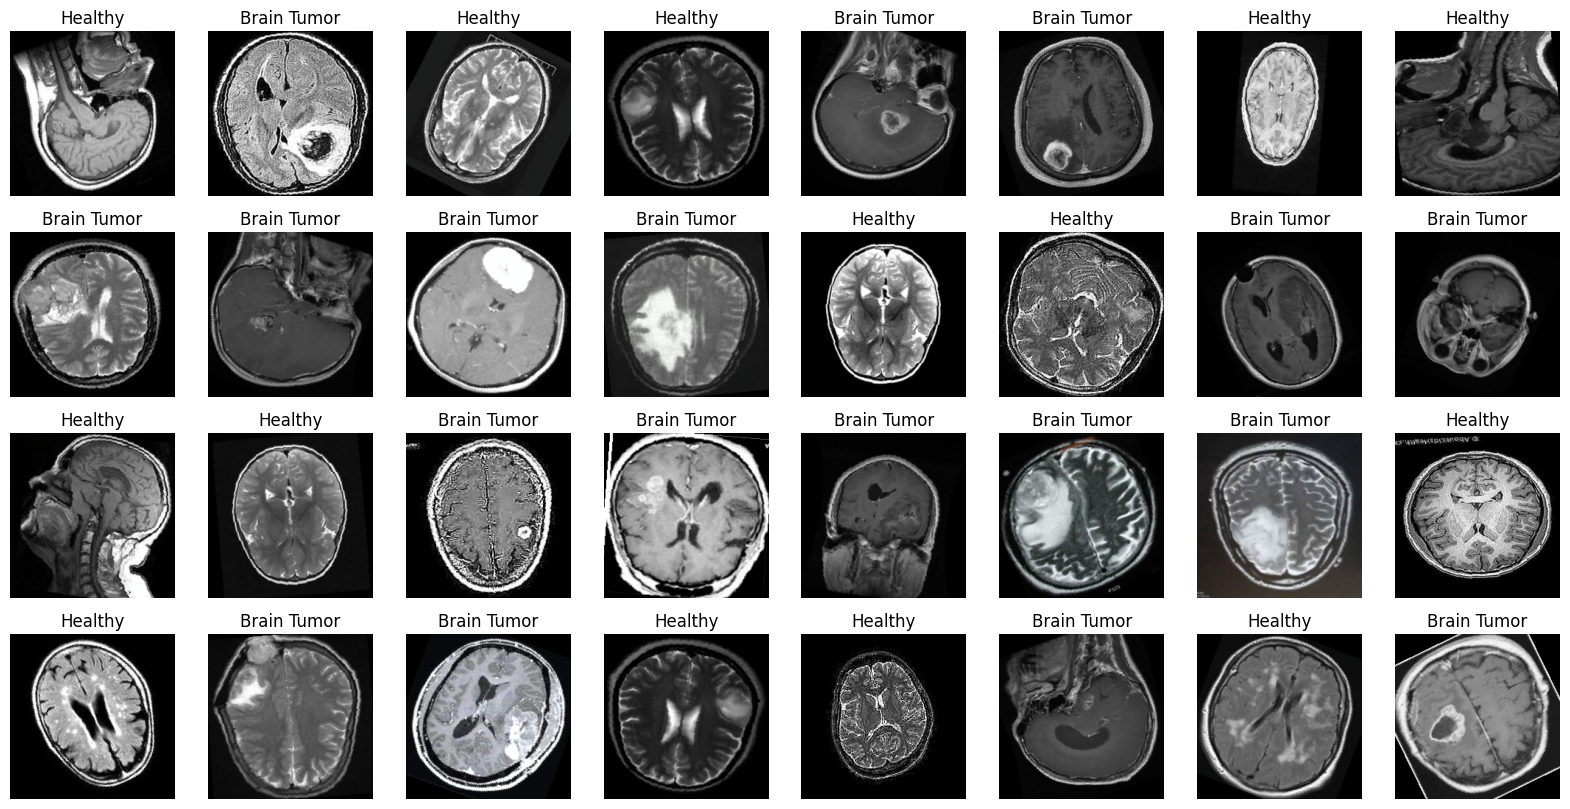

In [ ]:
def imshow_with_labels(inputs, classes, class_names):
    """Imshow for Tensor with labels."""
    # Unnormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    batch_size = inputs.size(0)
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(batch_size):
        inp = inputs[i].numpy().transpose((1, 2, 0))
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        ax = axes[i]
        ax.imshow(inp)
        ax.set_title(class_names[classes[i]])
        ax.axis('off')

    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))
class_names = dataset.classes

# Make a grid from batch
imshow_with_labels(inputs, classes, class_names)

### Instatiating the model

In [ ]:
# utilizando uma gpu, caso esteja disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# vgg16 pré treinada
vgg16 = models.vgg16(pretrained=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 13%|█▎        | 69.0M/528M [00:00<00:03, 125MB/s] 

100%|██████████| 528M/528M [00:04<00:00, 124MB/s] 


In [ ]:
# ajeitando a camada de saída, para ter a mesma quantidade de neurônios que a quantidade de classes
print(vgg16.classifier[6])
num_classes = len(class_names)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=2, bias=True)


In [ ]:
# movendo para a gpu
vgg16 = vgg16.to(device)

### Aux functions

In [ ]:
# classe para registrar a loss durante o treinamento
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [ ]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [ ]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  # garantir que só printe o progresso das épocas 5 vezes
  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if epoch == EPOCHS:
      print(f"Train loss: {round(train_loss, 6):<7}")
      print(f"Valid. loss: {round(val_loss, 6):<7}\n")

  # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1

  # plotar o gráfico de loss
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

In [ ]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    #labels = list(str(i) for i in range(10))
    labels = class_names
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

### Traning just the FC layers

Primeiramente vamos tentar treinar apenas as camadas Fully Connected

In [ ]:
# desativando o cálculo dos gradientes nas camadas convolucionais
for param in vgg16.features.parameters():
    param.requires_grad = False

Train loss: 0.153704
Valid. loss: 0.117025



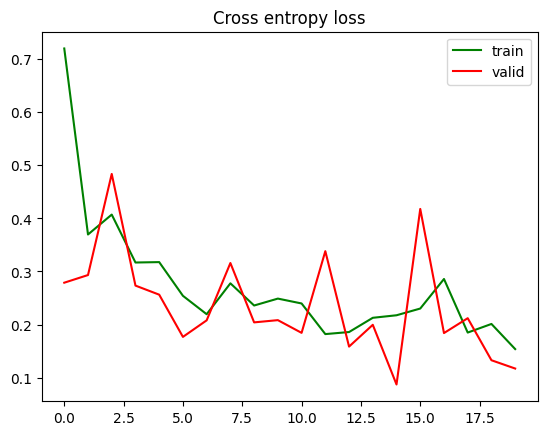

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimzer = optim.Adam(vgg16.classifier.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

Tentaremos treinar por mais 10 épocas, utilizando uma learning rate menor, como a loss variou bastante durante o treinamento, isso talvez ajude a ter um treinamento mais estável.

In [ ]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9832    0.9412    0.9617       187
     Healthy     0.9286    0.9795    0.9533       146

    accuracy                         0.9580       333
   macro avg     0.9559    0.9603    0.9575       333
weighted avg     0.9593    0.9580    0.9581       333



Train loss: 0.059437
Valid. loss: 0.188713



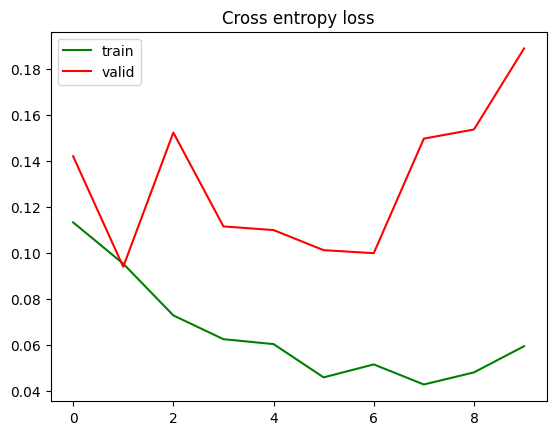

In [ ]:
LEARNING_RATE = 0.0001
EPOCHS = 10
optimzer = optim.Adam(vgg16.classifier.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [ ]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9735    0.9840    0.9787       187
     Healthy     0.9792    0.9658    0.9724       146

    accuracy                         0.9760       333
   macro avg     0.9764    0.9749    0.9756       333
weighted avg     0.9760    0.9760    0.9760       333



A acurácia aumentou em quase 2%. Podemos salvar esse modelo e tentar agora treinar as camadas convolucionais.

In [ ]:
torch.save(vgg16.state_dict(), 'pre_trained.vgg')

### Training the convolutional layers

In [ ]:
for name, param in vgg16.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is frozen
features.0.bias is frozen
features.2.weight is frozen
features.2.bias is frozen
features.5.weight is frozen
features.5.bias is frozen
features.7.weight is frozen
features.7.bias is frozen
features.10.weight is frozen
features.10.bias is frozen
features.12.weight is frozen
features.12.bias is frozen
features.14.weight is frozen
features.14.bias is frozen
features.17.weight is frozen
features.17.bias is frozen
features.19.weight is frozen
features.19.bias is frozen
features.21.weight is frozen
features.21.bias is frozen
features.24.weight is frozen
features.24.bias is frozen
features.26.weight is frozen
features.26.bias is frozen
features.28.weight is frozen
features.28.bias is frozen
classifier.0.weight is not frozen
classifier.0.bias is not frozen
classifier.3.weight is not frozen
classifier.3.bias is not frozen
classifier.6.weight is not frozen
classifier.6.bias is not frozen


In [ ]:
# congelando as camadas Fully Connected e descongelando as convolucionais
for param in vgg16.features.parameters():
    param.requires_grad = True

for param in vgg16.classifier.parameters():
    param.requires_grad = False

In [ ]:
for name, param in vgg16.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is not frozen
features.0.bias is not frozen
features.2.weight is not frozen
features.2.bias is not frozen
features.5.weight is not frozen
features.5.bias is not frozen
features.7.weight is not frozen
features.7.bias is not frozen
features.10.weight is not frozen
features.10.bias is not frozen
features.12.weight is not frozen
features.12.bias is not frozen
features.14.weight is not frozen
features.14.bias is not frozen
features.17.weight is not frozen
features.17.bias is not frozen
features.19.weight is not frozen
features.19.bias is not frozen
features.21.weight is not frozen
features.21.bias is not frozen
features.24.weight is not frozen
features.24.bias is not frozen
features.26.weight is not frozen
features.26.bias is not frozen
features.28.weight is not frozen
features.28.bias is not frozen
classifier.0.weight is frozen
classifier.0.bias is frozen
classifier.3.weight is frozen
classifier.3.bias is frozen
classifier.6.weight is frozen
classifier.6.bias is frozen


Train loss: 0.46795
Valid. loss: 0.436534



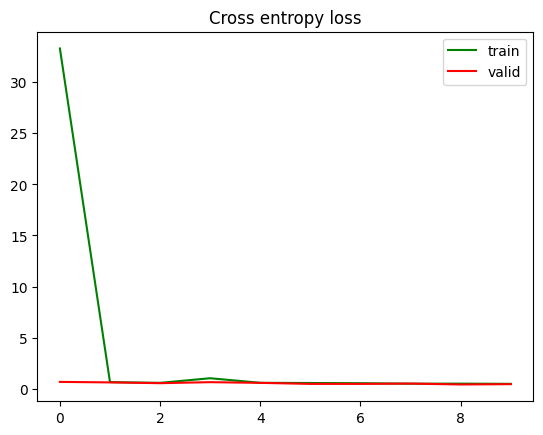

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 10
optimzer = optim.Adam(vgg16.features.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [ ]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.7544    0.9198    0.8289       187
     Healthy     0.8571    0.6164    0.7171       146

    accuracy                         0.7868       333
   macro avg     0.8058    0.7681    0.7730       333
weighted avg     0.7994    0.7868    0.7799       333



Houve uma grande queda na acurácia, demonstrando que talvez seja melhor manter a camada convolucional pré treinada.

### Testing the model

In [ ]:
# instanciar um novo vgg
vgg16 = models.vgg16(pretrained=True)

# ajeitar a camada de saída
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# carregar o modelo que salvamos
vgg16.load_state_dict(torch.load('pre_trained.vgg'))
vgg16 = vgg16.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9881    0.9842    0.9861       253
     Healthy     0.9808    0.9855    0.9831       207

    accuracy                         0.9848       460
   macro avg     0.9844    0.9848    0.9846       460
weighted avg     0.9848    0.9848    0.9848       460



In [ ]:
def test_plot(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []
    wrong_preds = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        instances = instances.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        corrects = preds == labels
        incorrect_indices = ~corrects

        total_corrects += corrects.sum().item()
        total_n += len(instances)

        all_probs.append(probabilities.cpu())
        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())

        # salvando as imagens erradas para mostrá-las posteriormente
        for idx in incorrect_indices.nonzero(as_tuple=True)[0]:
            img = instances[idx].cpu()
            pred_label = preds[idx].item()
            true_label = labels [idx].item()
            wrong_preds.append((img, pred_label, true_label))

    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    return (preds, targets, wrong_preds)

In [ ]:
all_preds, all_targets, wrong_preds = test_plot(vgg16, test_loader, device)

In [ ]:
# apenas 7 erros
len(wrong_preds)

7

In [ ]:
# acuracia de 98.48% no conjunto de teste
print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0, digits=4))

              precision    recall  f1-score   support

 Brain Tumor     0.9834    0.9875    0.9854       240
     Healthy     0.9863    0.9818    0.9841       220

    accuracy                         0.9848       460
   macro avg     0.9849    0.9847    0.9848       460
weighted avg     0.9848    0.9848    0.9848       460



In [ ]:
class_names

['Brain Tumor', 'Healthy']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


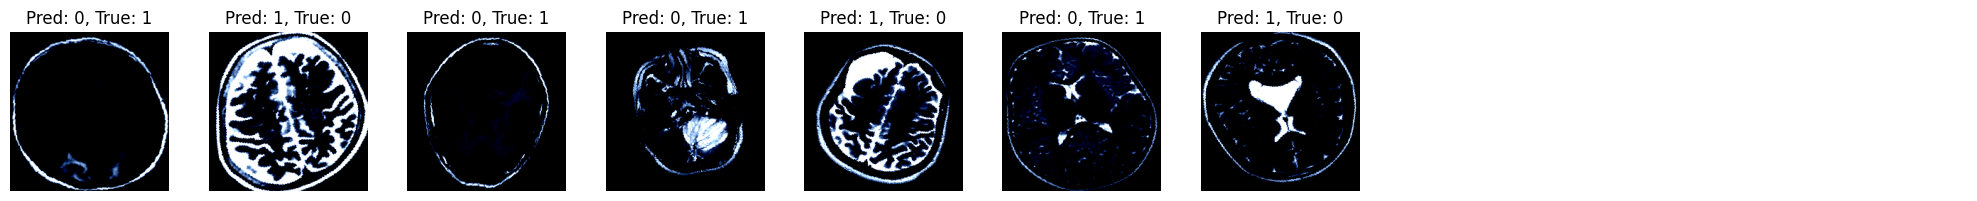

In [ ]:
def plot_wrong_predictions(wrong_preds, num_images=30):
    num_images = min(num_images, len(wrong_preds))
    num_cols = 10
    num_rows = (num_images + num_cols - 1) // num_cols  # Compute the number of rows needed

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_images):
        img, pred, true = wrong_preds[i]
        ax = axes[i]

        # Transpose image if it's in (channels, height, width) format
        if img.shape[0] == 3:  # Check if the image has 3 channels
            img = img.permute(1, 2, 0)

        ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
        ax.set_title(f"Pred: {pred}, True: {true}")
        ax.axis('off')

    # Hide any unused axes if there are less than num_images wrong predictions
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display wrong predictions
plot_wrong_predictions(wrong_preds)

### Training a new model

Dessa vez, tentaremos treinar com uma learning rate menor desde o início, já que, usando 1e-3 a loss ficou muito instável.

In [ ]:
model = models.vgg16(pretrained=True)

# adapting the output layer so it maches the amount of classes
print(model.classifier[6])
num_classes = len(class_names)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
print(model.classifier[6])

model = model.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=2, bias=True)


In [ ]:
# desativando calculo de gradiente das convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

Train loss: 0.028005
Valid. loss: 0.056398



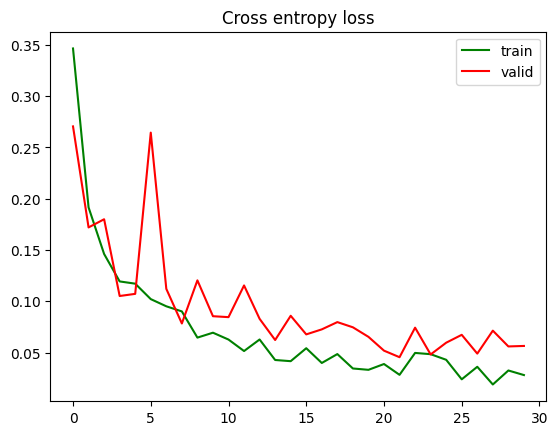

In [ ]:
# Learning rate de 1e-4
LEARNING_RATE = 0.0001
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

train(model, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [ ]:
result = test(model, test_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9793    0.9833    0.9813       240
     Healthy     0.9817    0.9773    0.9795       220

    accuracy                         0.9804       460
   macro avg     0.9805    0.9803    0.9804       460
weighted avg     0.9804    0.9804    0.9804       460



O treinamento foi bem mais estável, utilizando uma learning rate menor, podemos tentar treinar por mais algumas épocas com uma learning rate ainda menor.

Train loss: 0.005337
Valid. loss: 0.052497



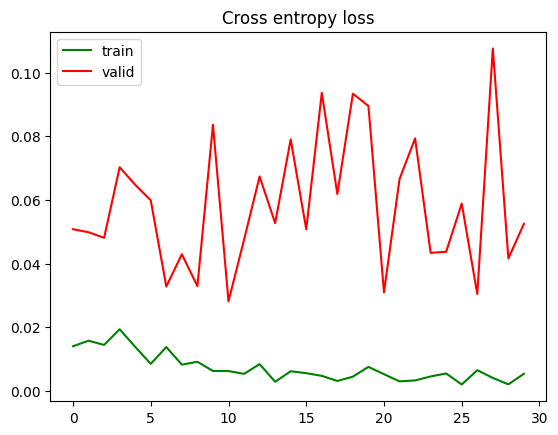

In [ ]:
# 1e-5, por mais 30 épocas
LEARNING_RATE = 0.00001
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

train(model, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [ ]:
result = test(model, test_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9835    0.9958    0.9896       240
     Healthy     0.9954    0.9818    0.9886       220

    accuracy                         0.9891       460
   macro avg     0.9895    0.9888    0.9891       460
weighted avg     0.9892    0.9891    0.9891       460



Obtivemos uma melhoria na acurácia, e a loss ficou com uma grande variação, pode ser interessante treinar por mais tempo com uma learning rate menor.

Train loss: 0.002948
Valid. loss: 0.046702



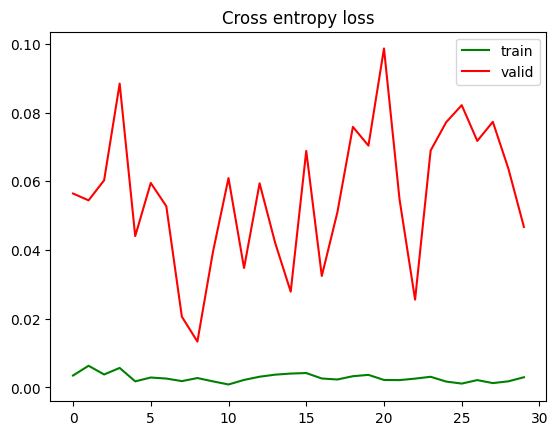

In [ ]:
# lr = 1e-6, 30 épocas
LEARNING_RATE = 0.000001
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

train(model, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [ ]:
result = test(model, test_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9876    0.9917    0.9896       240
     Healthy     0.9909    0.9864    0.9886       220

    accuracy                         0.9891       460
   macro avg     0.9892    0.9890    0.9891       460
weighted avg     0.9891    0.9891    0.9891       460



Não obtivemos nenhuma melhoria, apesar de diminuir a loss de validação.

In [ ]:
# Testes com o conjunto de teste
all_preds, all_targets, wrong_preds = test_plot(model, test_loader, device)

In [ ]:
# apenas 6 erros, de um total de 460
len(wrong_preds)

6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


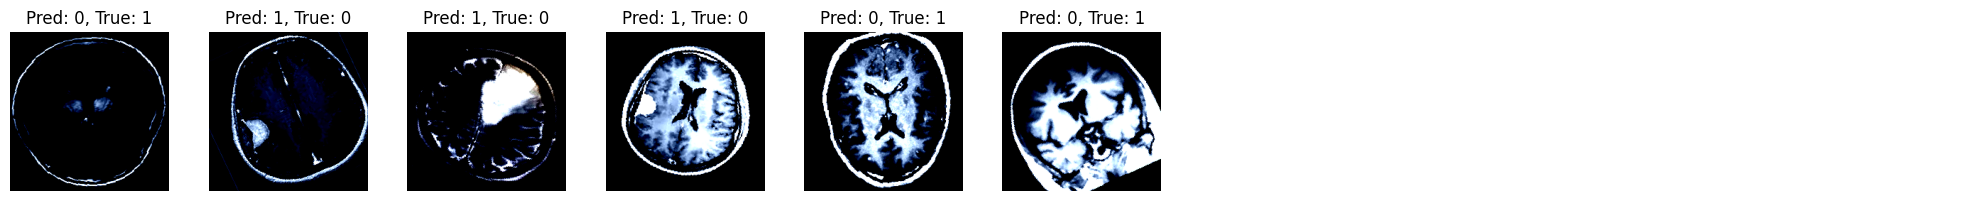

In [ ]:
plot_wrong_predictions(wrong_preds)

In [ ]:
torch.save(model.state_dict(), 'final_model.vgg')